<a href="https://colab.research.google.com/github/dipayandas97/Indoor-Navigation-System/blob/master/Optimizing_SNN_using_Genetic_Algorithm_Indoor_Localization_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from SNN_localization_preprocessing import transform_data
from neuron_models import LIF
from GA import GA

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data preparation

In [3]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
transform = transform_data(path='/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl')
X, Y = transform.get_spiketime_data()
signal_X, signal_Y = transform.get_temporal_vector_data(X,Y)
X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)

Train sizes:  (4080, 4, 749) (4080, 2, 749)
Test sizes:  (1020, 4, 749) (1020, 2, 749)


#Network definition

In [0]:
#Network-----------------------------------------------------------------------------------------------------------------------------------------------
dt = 0.125 #ms
m, n = 4, 2 
h_layer = []
for i in range(n):
    neuron = LIF(threshold=0.01, dt=dt)
    h_layer.append(neuron)

synapse_dim = (1,1,n,m)

In [0]:
#Network-----------------------------------------------------------------------------------------------------------------------------------------------
dt = 0.125 #ms

input_layer_dim = 4
num_neurons = [6, 2]
num_layers = len(num_neurons)
layers = []

for l in range(num_layers):
    this_layer = []
    for n in range(num_neurons[l]):
        this_layer.append(LIF(threshold=0.01, dt=dt))
    layers.append(this_layer)
    
synapse_dim = (1,1,n,m)

#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 5:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1] - true_timestamps[d]

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    #print(true_timestamps, pred_timestamps)                    
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##fitness()

In [0]:
#Simulation for calculating fitness of each synapse_matrix solution------------------------------------------------------------------------------------

simulation_time = 748 #Max temporal lenght of (input,output) signal

def fitness(population): #array of vectors
    train_score, test_score = [], []
    synapses = ga.vector_to_matrix(population, synapse_dim)
    
    for idx, s in enumerate(synapses):
        print('Solution:',idx+1,'/',synapses.shape[0])
        synapse = s[0] #since single hidden layer

        #Error on train_data
        temp_train_score = []      
        for i in range(X_train.shape[0]):     
            signal = X_train[i] #Input
            activations=[]      #Output
      
            for l in range(n):
                activations.append([0])
                h_layer[l].initialize()

            for t in range(simulation_time):            
                for idx,neuron in enumerate(h_layer):
                    input_I = np.dot(synapse[idx], signal[:,t])
                    activations[idx].append(neuron.update(input_I, t))
            activations = np.asarray(activations)
            
            temp_train_score.append( error(y_train[i],activations) )
            
        #calculate mean train error for this particular synapse matrix
        train_score.append(np.mean(temp_train_score))
        
        #Error on test data
        temp_test_score = []        
        for i in range(X_test.shape[0]):     
            signal = X_test[i] #Input
            activations=[]     #Output
      
            for l in range(n):
                activations.append([0])
                h_layer[l].initialize()

            for t in range(simulation_time):            
                for idx,neuron in enumerate(h_layer):
                    input_I = np.dot(synapse[idx], signal[:,t])
                    activations[idx].append(neuron.update(input_I, t))
            activations = np.asarray(activations)
            
            temp_test_score.append( error(y_test[i],activations) )
            
        #calculate mean test error for this particular synapse matrix
        test_score.append(np.mean(temp_test_score))   

    return train_score, test_score

##mp_fitness()

In [0]:
#Testing multi-proecssing
simulation_time = 748 #Max temporal lenght of (input,output) signal

def mp_fitness(synapse_vector, output): #fitness of one vectored synapse
    
    #Network instance for this sub-process-----------------------------------------------------------------------------------------------------------------------------------------------
    dt = 0.125 #ms
    m, n = 4, 2 
    h_layer = []
    for i in range(n):
        neuron = LIF(threshold=0.01, dt=dt)
        h_layer.append(neuron)    
    #--------------------------------------------------------------------------------------------------------------------------------------------
    
    synapse_id = synapse_vector[-1] 
    synapse_vector = synapse_vector[:-1]
    synapse_vector = synapse_vector.reshape(1, synapse_vector.shape[0])
    synapse = ga.vector_to_matrix(vectors = synapse_vector, matrices_dim=synapse_dim)[0][0]

    #Error on train_data
    temp_train_score = []      
    #for i in range(X_train.shape[0]):     
    for i in range(10):     
        signal = X_train[i] #Input
        activations=[]      #Output
    
        for l in range(n):
            activations.append([0])
            h_layer[l].initialize()

        for t in range(simulation_time):            
            for idx,neuron in enumerate(h_layer):
                input_I = np.dot(synapse[idx], signal[:,t])
                activations[idx].append(neuron.update(input_I, t))
        activations = np.asarray(activations)
        
        temp_train_score.append( error(y_train[i],activations) )

    #Error on test data
    temp_test_score = []        
    #for i in range(X_test.shape[0]):     
    for i in range(15):     
        signal = X_test[i] #Input
        activations=[]     #Output
    
        for l in range(n):
            activations.append([0])
            h_layer[l].initialize()

        for t in range(simulation_time):            
            for idx,neuron in enumerate(h_layer):
                input_I = np.dot(synapse[idx], signal[:,t])
                activations[idx].append(neuron.update(input_I, t))
        activations = np.asarray(activations)
        
        temp_test_score.append( error(y_test[i],activations) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Using multi-processing

In [0]:
import time
def dum(a, t, output):
    time.sleep(t)
    print(t)
    output.put(a)

In [69]:
import multiprocessing as mp
output = mp.Queue()

pop = np.arange(10)
t = np.concatenate([np.arange(10,5,-1), np.arange(6,10,1)])

processes=[]
for ix,syn in enumerate(pop):
    p = mp.Process(target = dum, args=(syn, t[ix-1], output))
    processes.append(p)

for p in processes:
    p.start()

for p in processes:
    p.join()

results = [output.get() for p in processes]

print(results)

6
6
7
7
8
8
9
9
9
10
[5, 6, 4, 7, 3, 8, 0, 2, 9, 1]


In [67]:
t

array([9, 8, 7, 6, 6, 7, 8, 9])

In [38]:
import multiprocessing as mp
output = mp.Queue()

pop = np.random.uniform(-1.,2.,size=(2, 1, n, m))

processes=[]
for syn in pop:
    p = mp.Process(target = mp_fitness, args=(syn, output))
    processes.append(p)

for p in processes:
    p.start()

for p in processes:
    p.join()

results = [output.get() for p in processes]

print(results)

Training chromosome:  [[[ 0.44329736  1.04577818  1.11899767  0.64994026]
  [ 1.13565153 -0.60587481  0.7830648  -0.00432822]]]
Training chromosome:  [[[ 0.80797252  1.52172621  0.36678232  1.6529984 ]
  [ 0.86253905 -0.43839262  1.89781122  1.92233191]]]
Testing chromosome:  [[[ 0.80797252  1.52172621  0.36678232  1.6529984 ]
  [ 0.86253905 -0.43839262  1.89781122  1.92233191]]]
Testing chromosome:  [[[ 0.44329736  1.04577818  1.11899767  0.64994026]
  [ 1.13565153 -0.60587481  0.7830648  -0.00432822]]]
[[307.4229740256599, 306.98612810550134], [161.95301944194773, 162.64077106885355]]


##sequential GA

In [0]:
#Genetic algorithm parameters:------------------------------------------------------------------------------------------------------------------------
#    Mating Pool Size (Number of Parents)
#    Population Size
#    Number of Generations
#    Mutation Percent

sol_per_pop = 200
num_parents_mating = 50
num_generations = 500
mutation_percent = 30
ga = GA()

#initial population :         
initial_population_weights = np.random.uniform(-1.,2.,size=(sol_per_pop, 1, n, m))
population_matrices = initial_population_weights
population_vectors = ga.matrix_to_vector(initial_population_weights)

train_error, test_error = [], []

for generation in range(num_generations):
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    
    #Calculate fitness for each population_vector in population    
    fitness_train, fitness_test = fitness(population_vectors)
    
    train_error.append(np.min(fitness_train))
    test_error.append(np.min(fitness_test))
    print('Train Error:', train_error[-1])
    print('Test Error:', test_error[-1])
    
    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    print(parents.shape[0],'New parents generated...')
    
    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    print('New population created')
    
    #Update the result of this generation in report files
    f = open('train_error.pkl','wb')
    pickle.dump(train_error, f)
    f.close()
    f = open('test_error.pkl','wb')
    pickle.dump(test_error, f)
    f.close()
    f = open('best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()

    plt.plot(train_error)
    plt.plot(test_error)
    plt.show()

##Parallel GA

Generation :  1 / 500
Train Error: 398.05374576844883
Test Error: 344.89741108277633
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


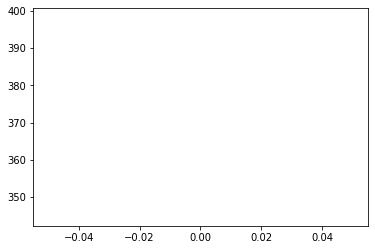

Generation :  2 / 500
Train Error: 249.01011475194588
Test Error: 224.03771308291766
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


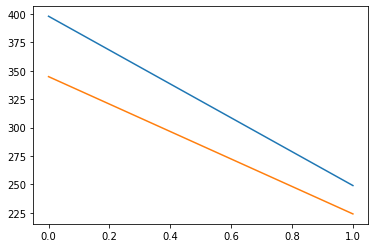

Generation :  3 / 500
Train Error: 157.38509892714035
Test Error: 174.07903845418414
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


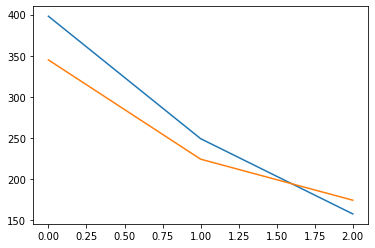

Generation :  4 / 500
Train Error: 134.52933021805282
Test Error: 179.05738564500123
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


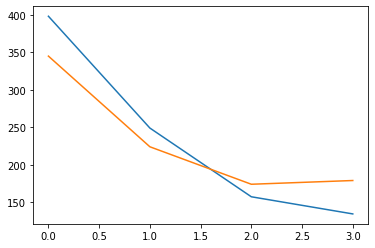

Generation :  5 / 500
Train Error: 127.83045684825544
Test Error: 176.11483850239608
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


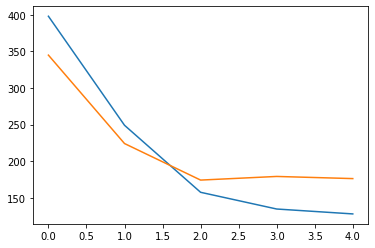

Generation :  6 / 500
Train Error: 127.22744279241628
Test Error: 176.65458993518317
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


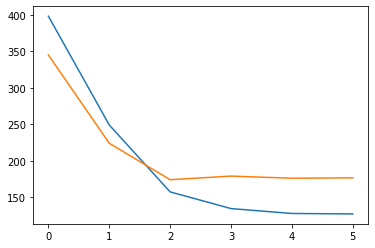

Generation :  7 / 500
Train Error: 131.9113467438623
Test Error: 177.1884276578865
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


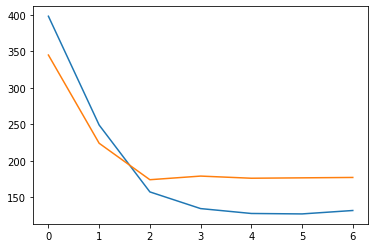

Generation :  8 / 500
Train Error: 129.88715167648132
Test Error: 179.2874364689352
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


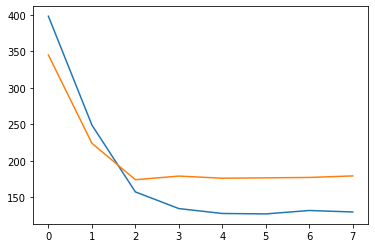

Generation :  9 / 500
Train Error: 131.50730265159066
Test Error: 180.41215692367584
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


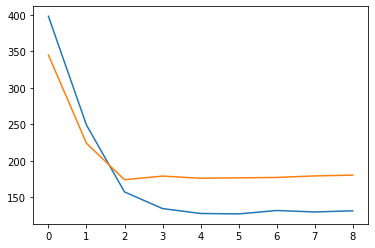

Generation :  10 / 500
Train Error: 130.9211631299023
Test Error: 179.59698178629966
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


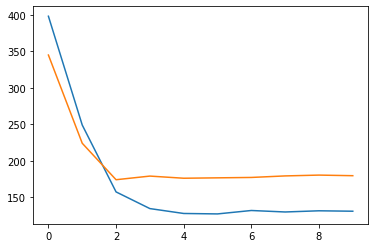

Generation :  11 / 500
Train Error: 128.16668061551331
Test Error: 178.09461634190436
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


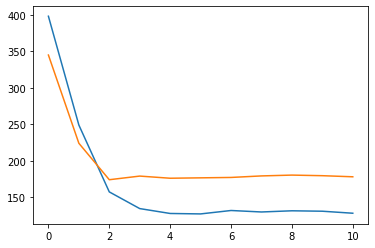

Generation :  12 / 500
Train Error: 127.04254838470013
Test Error: 180.19370849225416
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


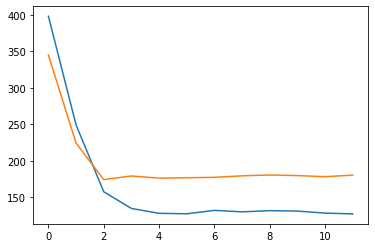

Generation :  13 / 500
Train Error: 124.4864296749586
Test Error: 178.1318837564607
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


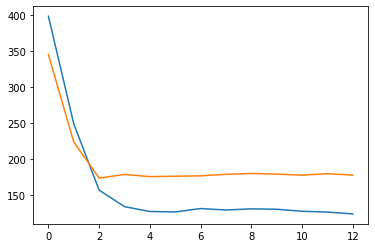

Generation :  14 / 500
Train Error: 128.94198066660775
Test Error: 177.649762932823
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


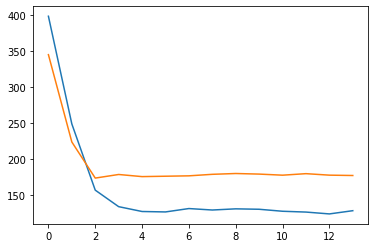

Generation :  15 / 500
Train Error: 131.09149798578113
Test Error: 178.64742464923228
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


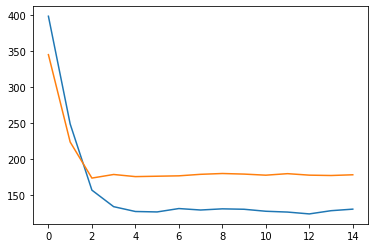

Generation :  16 / 500
Train Error: 128.2203694310626
Test Error: 179.30594000657172
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


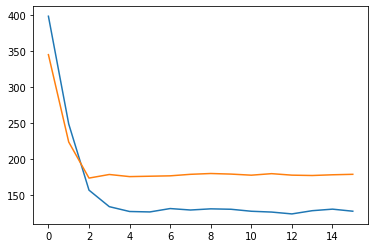

Generation :  17 / 500
Train Error: 130.81989389847854
Test Error: 183.40765343038453
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


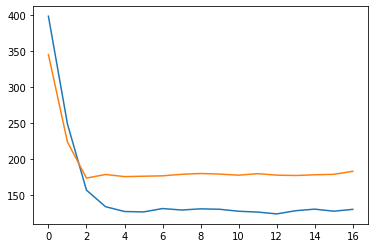

Generation :  18 / 500
Train Error: 128.1189661683377
Test Error: 180.5492191730226
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


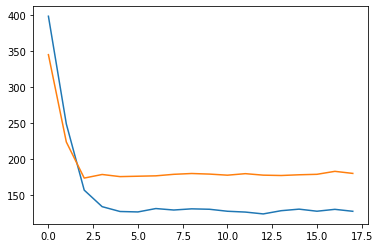

Generation :  19 / 500
Train Error: 129.65353958802604
Test Error: 180.0420407762863
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


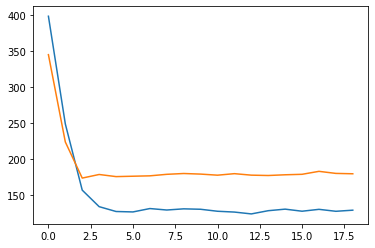

Generation :  20 / 500
Train Error: 129.4422113714184
Test Error: 178.86445863940648
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


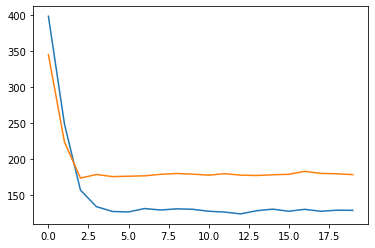

Generation :  21 / 500
Train Error: 129.83734206993913
Test Error: 181.41702776369945
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


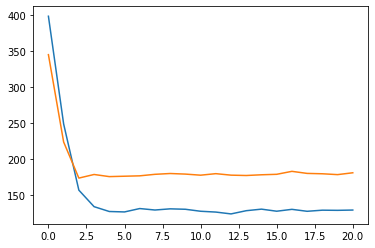

Generation :  22 / 500
Train Error: 132.05553434573991
Test Error: 179.93254090220827
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


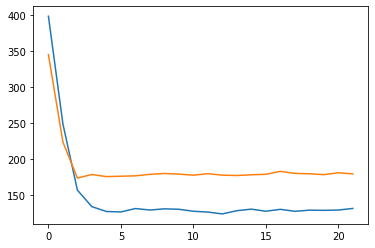

Generation :  23 / 500
Train Error: 131.8098361805371
Test Error: 180.8340208451978
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


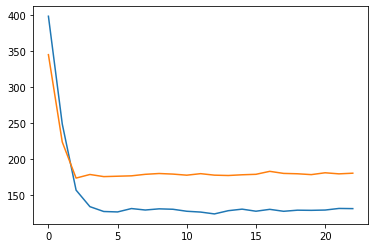

Generation :  24 / 500
Train Error: 127.34170453438905
Test Error: 177.00840946793403
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


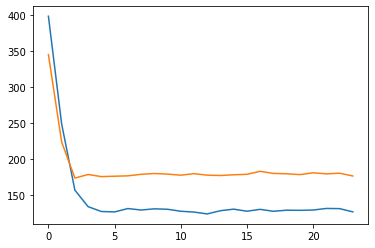

Generation :  25 / 500
Train Error: 134.02968220411856
Test Error: 181.06120362393492
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


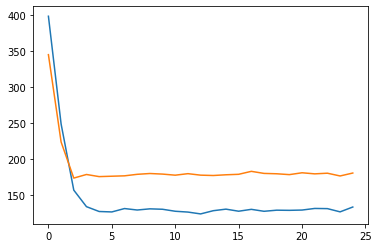

Generation :  26 / 500
Train Error: 130.03920732713607
Test Error: 178.75735704539235
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


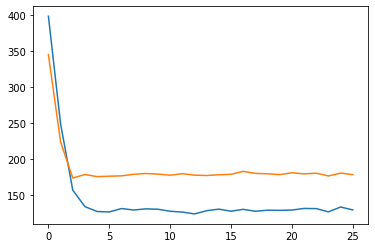

Generation :  27 / 500
Train Error: 131.4461733559013
Test Error: 177.7484833160106
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


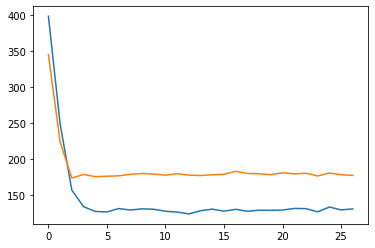

Generation :  28 / 500
Train Error: 131.46948933679988
Test Error: 180.34686815878413
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


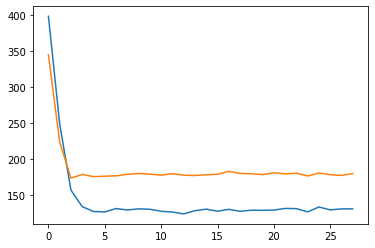

Generation :  29 / 500
Train Error: 133.00088009428183
Test Error: 180.6771205088357
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


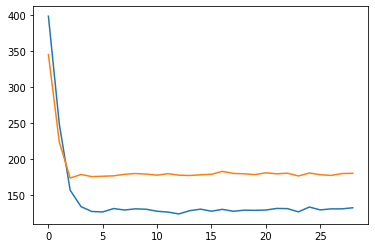

Generation :  30 / 500
Train Error: 131.0786148999018
Test Error: 178.67408804730795
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


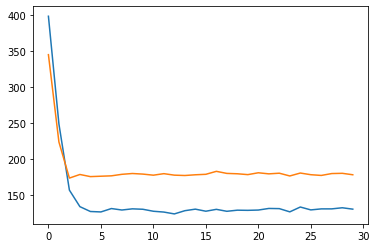

Generation :  31 / 500
Train Error: 125.87942684424438
Test Error: 179.04899828659342
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


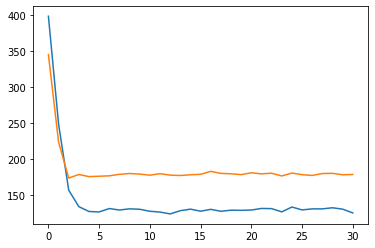

Generation :  32 / 500
Train Error: 131.12297745321501
Test Error: 179.87027651745083
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


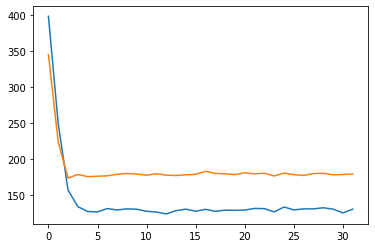

Generation :  33 / 500
Train Error: 130.96280178514255
Test Error: 178.31686102539845
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


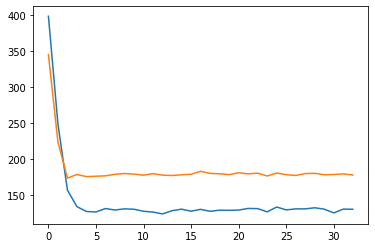

Generation :  34 / 500
Train Error: 127.24707691880667
Test Error: 178.5378621414175
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


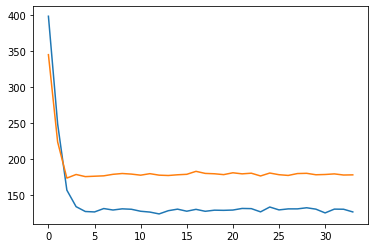

Generation :  35 / 500
Train Error: 127.90575601420787
Test Error: 180.83173528844702
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


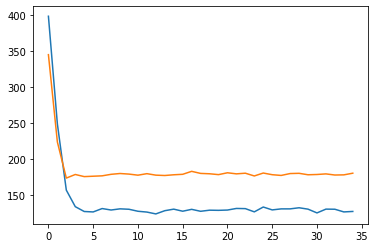

Generation :  36 / 500
Train Error: 129.09050337188665
Test Error: 181.06838934872977
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


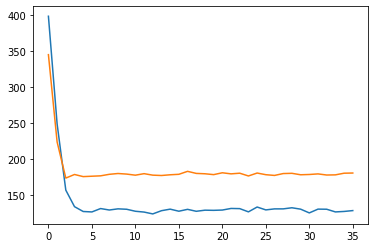

Generation :  37 / 500
Train Error: 128.99621389623744
Test Error: 181.43367946706377
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


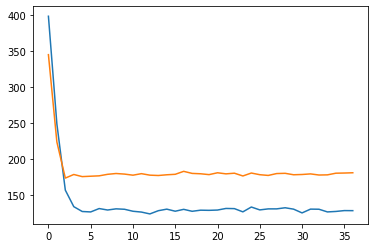

Generation :  38 / 500
Train Error: 130.45044956264758
Test Error: 179.63658747514984
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


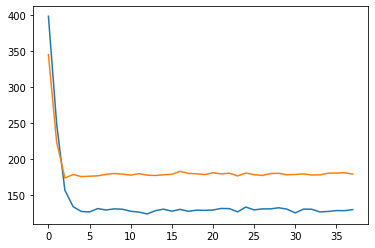

Generation :  39 / 500
Train Error: 133.10827933331493
Test Error: 180.5151903284731
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


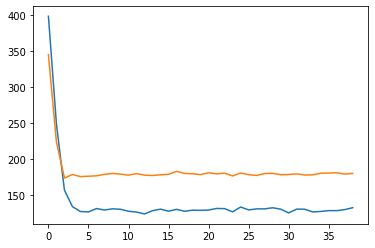

Generation :  40 / 500
Train Error: 132.4178652795964
Test Error: 179.75352043362597
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


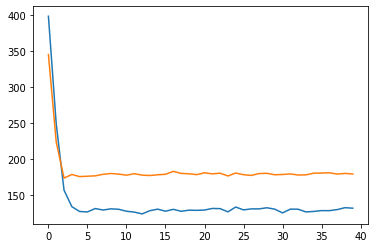

Generation :  41 / 500
Train Error: 129.95956617749619
Test Error: 180.3693630525942
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


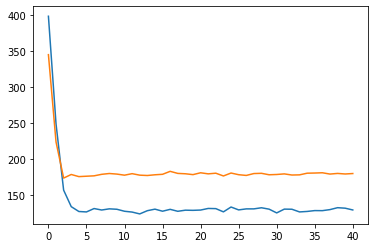

Generation :  42 / 500
Train Error: 133.9124565575196
Test Error: 181.53603459948278
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


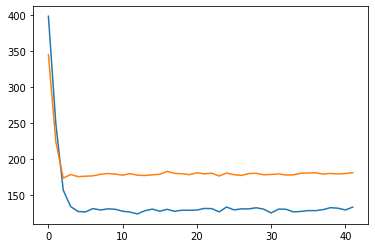

Generation :  43 / 500
Train Error: 128.29762177636138
Test Error: 179.58365486138206
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


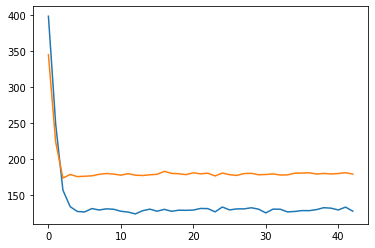

Generation :  44 / 500
Train Error: 130.78828054670606
Test Error: 179.96266867048828
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


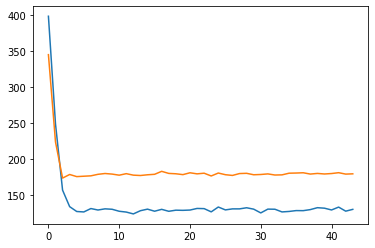

Generation :  45 / 500
Train Error: 130.4473278874453
Test Error: 182.2940480247792
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


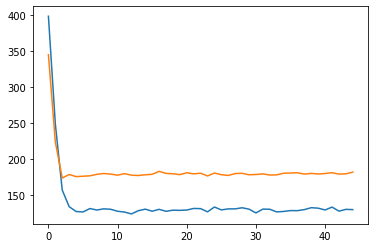

Generation :  46 / 500
Train Error: 127.43103353004041
Test Error: 178.7327741034685
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


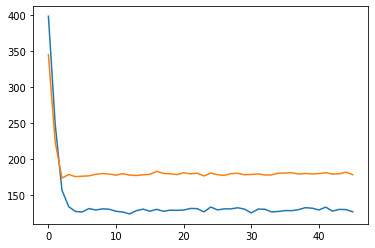

Generation :  47 / 500
Train Error: 128.7152877133948
Test Error: 177.22024360203963
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


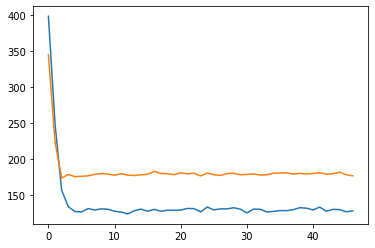

Generation :  48 / 500
Train Error: 132.39367548114353
Test Error: 182.24089853622317
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


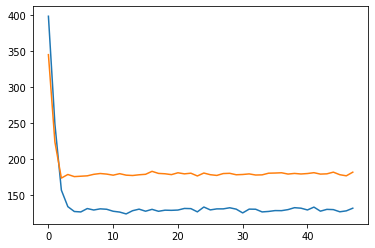

Generation :  49 / 500
Train Error: 128.42163542513197
Test Error: 178.06579378755353
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


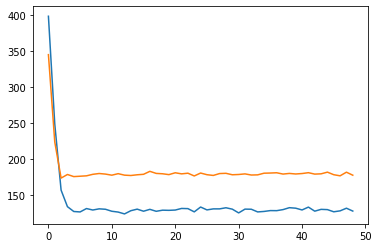

Generation :  50 / 500
Train Error: 130.39313437474567
Test Error: 178.71945573637745
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


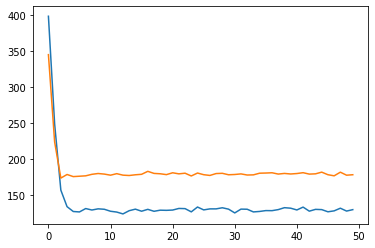

Generation :  51 / 500
Train Error: 130.4610787406533
Test Error: 179.51251658476787
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


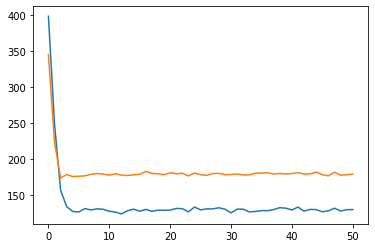

Generation :  52 / 500
Train Error: 131.42907401158277
Test Error: 180.82878431526137
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


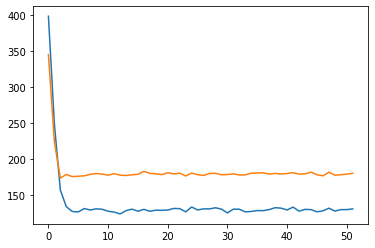

Generation :  53 / 500
Train Error: 130.41661203444622
Test Error: 181.51321916910283
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


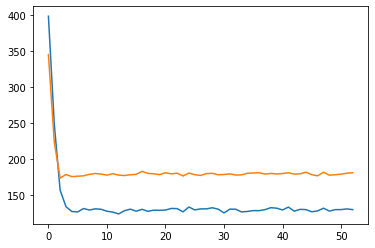

Generation :  54 / 500
Train Error: 127.37412507262023
Test Error: 176.5122060279433
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


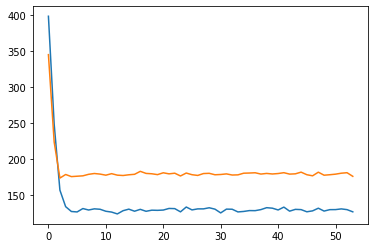

Generation :  55 / 500
Train Error: 131.65860684108225
Test Error: 179.251640440797
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


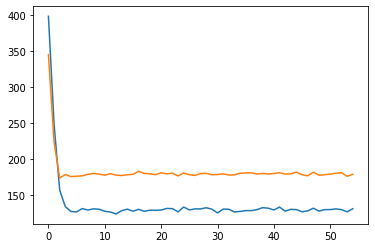

Generation :  56 / 500
Train Error: 130.441494215891
Test Error: 177.3417901885551
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


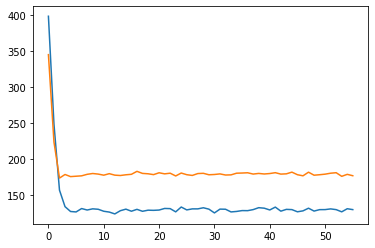

Generation :  57 / 500
Train Error: 128.78228311420543
Test Error: 179.0146938587724
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


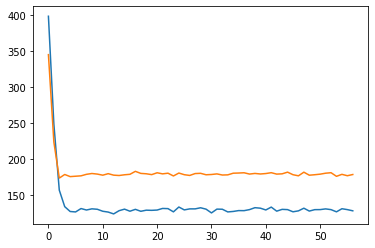

Generation :  58 / 500
Train Error: 126.2120451909554
Test Error: 178.4352860985755
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


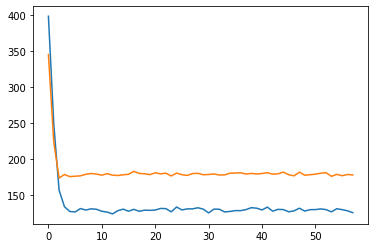

Generation :  59 / 500
Train Error: 129.24782903980216
Test Error: 178.648431219327
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


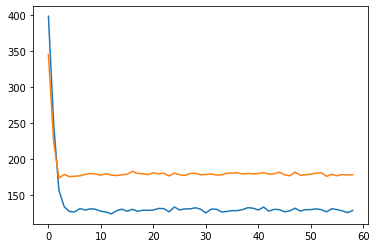

Generation :  60 / 500
Train Error: 130.88356665749595
Test Error: 179.88739330501653
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


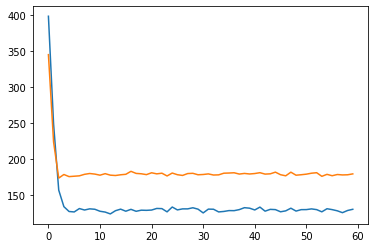

Generation :  61 / 500
Train Error: 129.62207506317935
Test Error: 180.27771648699192
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


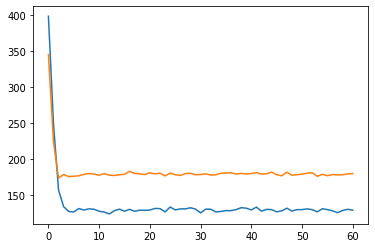

Generation :  62 / 500
Train Error: 133.79131726806128
Test Error: 183.9622899350496
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


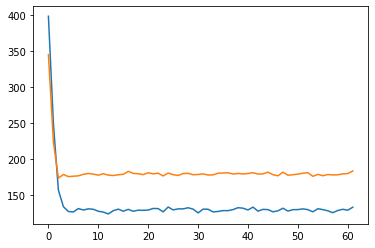

Generation :  63 / 500
Train Error: 128.7102215416141
Test Error: 178.08778266880722
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


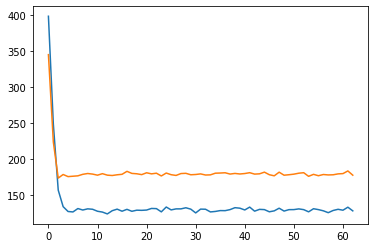

Generation :  64 / 500
Train Error: 131.7435189907346
Test Error: 179.6612602421286
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


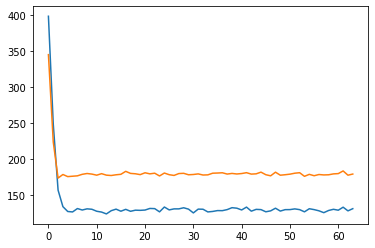

Generation :  65 / 500
Train Error: 128.26738542161354
Test Error: 177.34345400191467
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


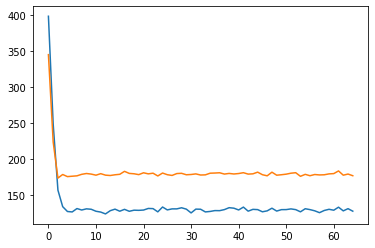

Generation :  66 / 500
Train Error: 131.24067624733715
Test Error: 180.65499013680687
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


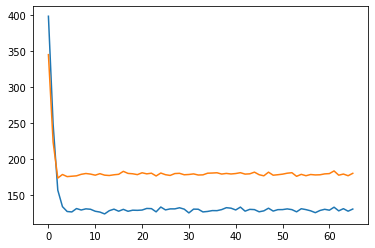

Generation :  67 / 500
Train Error: 125.74760679039765
Test Error: 178.41248326115794
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


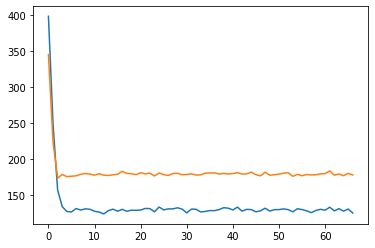

Generation :  68 / 500
Train Error: 129.46674335472574
Test Error: 179.03457017439644
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


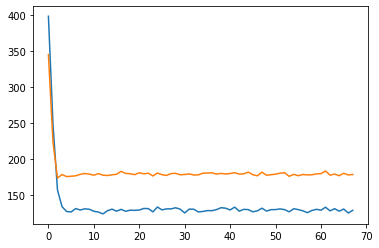

Generation :  69 / 500
Train Error: 128.59157144893078
Test Error: 176.83456378506196
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


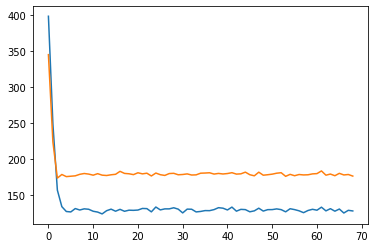

Generation :  70 / 500
Train Error: 127.19286768981452
Test Error: 177.81548983383675
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


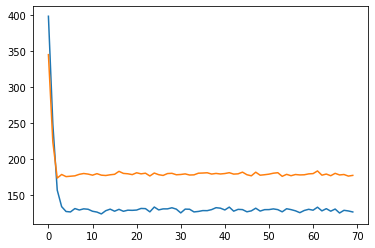

Generation :  71 / 500
Train Error: 124.03717661485408
Test Error: 180.54589881579508
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


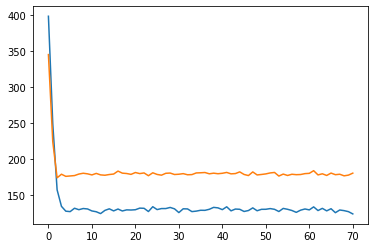

Generation :  72 / 500
Train Error: 131.95678608795725
Test Error: 179.21116064051108
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


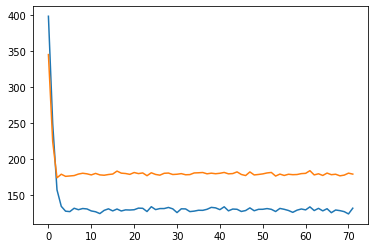

Generation :  73 / 500
Train Error: 131.05124989931699
Test Error: 181.64368989279137
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


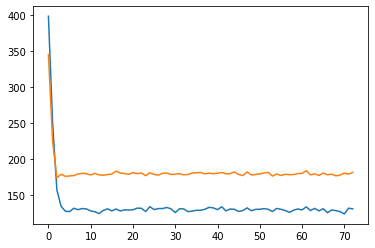

Generation :  74 / 500
Train Error: 129.51053028065
Test Error: 181.36842071137644
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


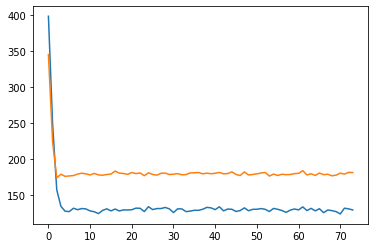

Generation :  75 / 500
Train Error: 129.433951377719
Test Error: 178.77461417186078
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


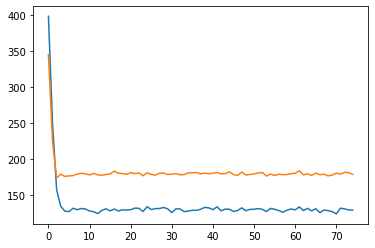

Generation :  76 / 500
Train Error: 131.80780490417203
Test Error: 179.74135702664506
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


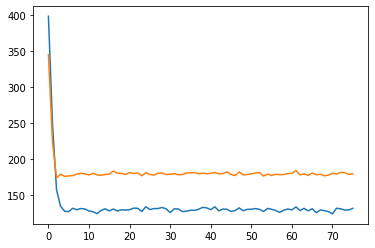

Generation :  77 / 500
Train Error: 125.87789941055425
Test Error: 177.06161454135238
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


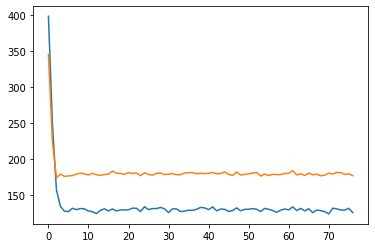

Generation :  78 / 500
Train Error: 125.34294323149476
Test Error: 178.06212070794535
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


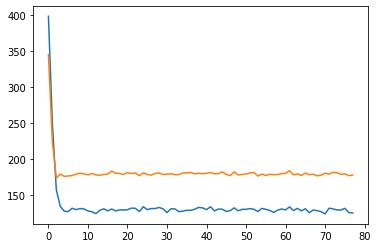

Generation :  79 / 500
Train Error: 128.80229349220036
Test Error: 180.13757464450674
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


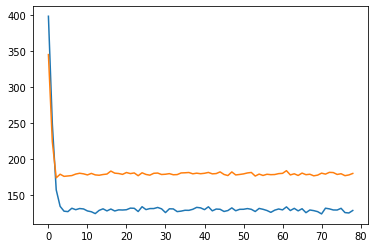

Generation :  80 / 500
Train Error: 129.1578786553734
Test Error: 179.71378896698775
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


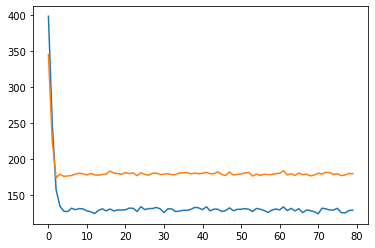

Generation :  81 / 500
Train Error: 129.3935562663241
Test Error: 180.4636188185349
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


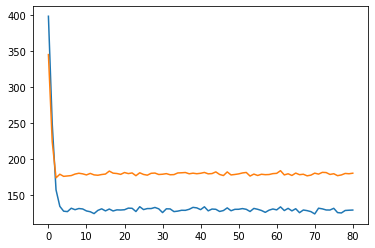

Generation :  82 / 500
Train Error: 134.8321233325452
Test Error: 181.93806172542637
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


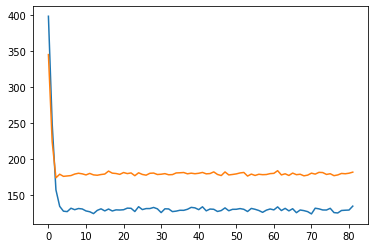

Generation :  83 / 500
Train Error: 129.86857609068196
Test Error: 178.94917739461133
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


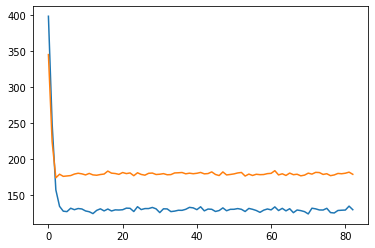

Generation :  84 / 500
Train Error: 126.75357873646772
Test Error: 181.63925388909797
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


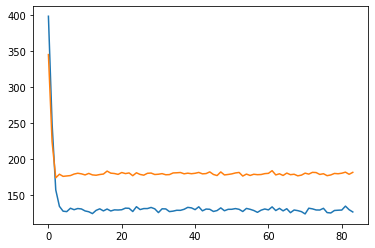

Generation :  85 / 500
Train Error: 128.19730021052428
Test Error: 178.736687824284
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


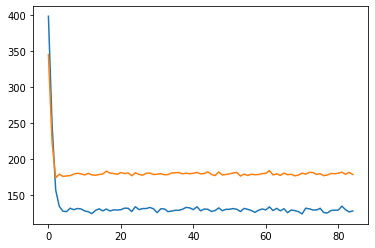

Generation :  86 / 500
Train Error: 131.28658656475264
Test Error: 180.98930553272868
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


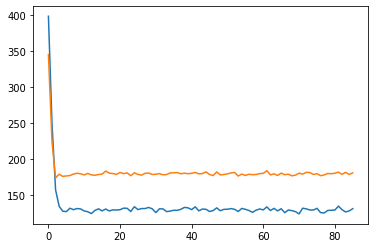

Generation :  87 / 500
Train Error: 131.46904358682718
Test Error: 183.5567909313595
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


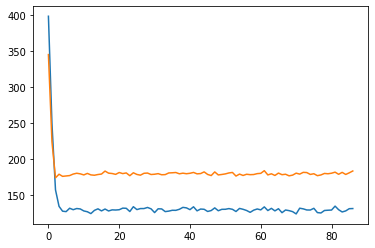

Generation :  88 / 500
Train Error: 128.01329055659303
Test Error: 178.74834846519892
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


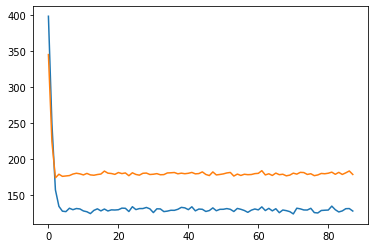

Generation :  89 / 500
Train Error: 130.25042848670927
Test Error: 179.86882572748328
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


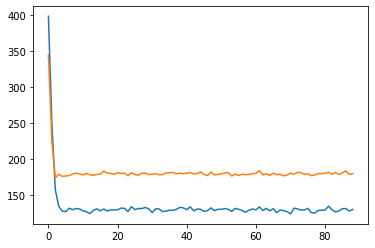

Generation :  90 / 500
Train Error: 128.6627267119368
Test Error: 180.0603196537323
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


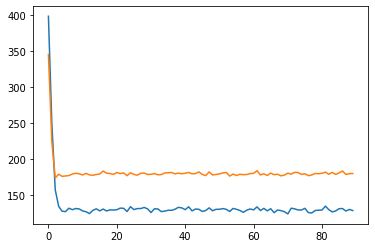

Generation :  91 / 500
Train Error: 130.3301671986785
Test Error: 178.98912954145032
50 New parents generated...
150 New offsprings produced...
150 offsprings mutated
New population created


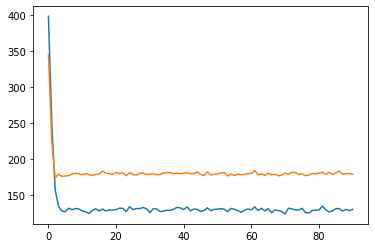

Generation :  92 / 500


Process Process-18374:
Process Process-18371:
Process Process-18379:
Process Process-18370:
Process Process-18390:
Process Process-18385:
Process Process-18384:
Process Process-18381:
Process Process-18378:
Process Process-18368:
Process Process-18363:
Process Process-18369:
Process Process-18364:
Process Process-18389:
Process Process-18377:
Process Process-18372:
Process Process-18366:
Process Process-18383:
Process Process-18392:
Process Process-18382:
Process Process-18388:
Process Process-18365:
Process Process-18391:
Process Process-18386:
Process Process-18367:
Process Process-18387:
Process Process-18380:
Process Process-18373:
Process Process-18376:
Process Process-18375:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call la

KeyboardInterrupt: ignored

In [6]:
import multiprocessing as mp
output = mp.Queue()

#Genetic algorithm parameters:------------------------------------------------------------------------------------------------------------------------
#    Mating Pool Size (Number of Parents)
#    Population Size
#    Number of Generations
#    Mutation Percent

sol_per_pop = 200
num_parents_mating = 50
num_generations = 500
mutation_percent = 30
ga = GA()

#initial population :         
synapse_dim = (1,1,2,4)
initial_population_weights = np.random.uniform(-2.,3.,size=(sol_per_pop, 1, 2, 4))
population_vectors = ga.matrix_to_vector(initial_population_weights)

train_error, test_error = [], []

for generation in range(num_generations):
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    
    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(population_vectors.shape[0]).reshape(population_vectors.shape[0],1)))
    
    processes=[]
    for syn in temp_population_vectors:
        p = mp.Process(target = mp_fitness, args=(syn, output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column
    
    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])

    train_error.append(np.mean(fitness_train))
    test_error.append(np.mean(fitness_test))
    print('Train Error:', train_error[-1])
    print('Test Error:', test_error[-1])
    
    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    print(parents.shape[0],'New parents generated...')
    
    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    print('New population created')
    
    #Update the result of this generation in report files
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
    pickle.dump(train_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
    pickle.dump(test_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()

    plt.plot(train_error)
    plt.plot(test_error)
    plt.show()